In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from brukeropusreader import read_file
from scipy.interpolate import interp1d


In [2]:
# Define folder paths (corrected paths for RE and OE)
folder_path_oe = 'Spectra RE'  # OE data actually in 'Spectra RE'
folder_path_re = 'Spectra OE'  # RE data actually in 'Spectra OE'
folder_path_trachea = 'Spectra TR'  # Trachea data is correct

# Function to list files in a folder
def list_files(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return files

# List files in each folder
files_re = list_files(folder_path_re)  # Actually RE data in 'Spectra OE'
files_oe = list_files(folder_path_oe)  # Actually OE data in 'Spectra RE'
files_tr = list_files(folder_path_trachea)  # Trachea data in 'Spectra TR'

# Displaying file names and their count
print("RE Folder:")
print(f"Number of files: {len(files_re)}")
print("Files:", files_re)

print("\nOE Folder:")
print(f"Number of files: {len(files_oe)}")
print("Files:", files_oe)

print("\nTrachea Folder:")
print(f"Number of files: {len(files_tr)}")
print("Files:", files_tr)

# Define the common set of wavenumbers
start_wavenumber = 5000  # Starting wavenumber
end_wavenumber = 400  # Ending wavenumber
resolution = 1  # Resolution in cm⁻¹

# Generate the common set of wavenumbers
common_wavenumbers = np.arange(start_wavenumber, end_wavenumber - resolution, -resolution)

# Verify the first and last values as well as the size of the set to ensure it matches expectations
print("First wavenumber:", common_wavenumbers[0])
print("Last wavenumber:", common_wavenumbers[-1])
print("Total number of points:", len(common_wavenumbers))

def get_wavenumbers(file_path):
    opus_data = read_file(file_path)
    # Assuming wavenumbers are stored in a key 'WN' in the returned data
    num_points = len(opus_data['AB'])
    start_wn = opus_data['AB Data Parameter']['FXV']
    end_wn = opus_data['AB Data Parameter']['LXV']
    # Generate the list of wavenumbers
    wavenumbers = np.linspace(start_wn, end_wn, num_points)
    return wavenumbers

def get_spectral_data(file_path):
    """
    Extracts spectral data (e.g., absorbance values) from a file.

    Parameters:
    - file_path: The path to the Bruker file.

    Returns:
    - A numpy array containing the spectral data.
    """
    opus_data = read_file(file_path)
    # Assuming the spectral data is stored in the 'AB' key
    spectral_data = opus_data['AB']
    return spectral_data

def interpolate_to_common_wavenumbers(file_path, common_wavenumbers):
    """
    Interpolates the spectral data from a file to a common set of wavenumbers.
    
    Parameters:
    - file_path: The path to the file.
    - common_wavenumbers: The common wavenumbers to interpolate the data to.
    
    Returns:
    - A numpy array of the interpolated spectral data.
    """
    original_wavenumbers = get_wavenumbers(file_path)
    original_data = get_spectral_data(file_path)
    interpolation_func = interp1d(original_wavenumbers, original_data, kind='linear', fill_value="extrapolate")
    interpolated_data = interpolation_func(common_wavenumbers)
    return interpolated_data

def z_score_normalize(data):
    """
    Normalizes a data array using Z-score normalization.
    
    Parameters:
    - data: A numpy array of spectral data.
    
    Returns:
    - The Z-score normalized spectral data.
    """
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = (data - mean) / std_dev
    return normalized_data

def process_directory(folder_path, common_wavenumbers):
    """
    Processes all files in a directory, interpolating and normalizing their spectral data.
    
    Parameters:
    - folder_path: The path to the directory.
    - common_wavenumbers: The common wavenumbers to interpolate the data to.
    
    Returns:
    - A numpy array of all the normalized spectral data from the directory.
    """
    normalized_data_list = []
    files = list_files(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data = interpolate_to_common_wavenumbers(file_path, common_wavenumbers)
        
        # Cut the spectra to the wavenumbers from 800 to 1900 cm⁻¹
        mask = (common_wavenumbers >= 900) & (common_wavenumbers <= 1800)
        data = data[mask]
        
        normalized_data = z_score_normalize(data)
        normalized_data_list.append(normalized_data)
    return np.array(normalized_data_list)

print("First wavenumber:", common_wavenumbers[0])
print("Last wavenumber:", common_wavenumbers[-1])
print("Total number of points:", len(common_wavenumbers))



RE Folder:
Number of files: 185
Files: ['20240408 A5 OE.0004', '20240408 A5 OE.0003', '20240408 A2 OE.0001', '20240311 OE 1.0003', '19022024 OE 4.0004', '05022024 OE 1 mit max druck.0004', '20240415 B5 OE.0002', '20240415 B2 OE.0000', '20240311 OE 1.0004', '05022024 OE 1 mit max druck.0003', '20240318 OE A2.0000', '20240311 OE 5.0001', '19022024 OE 4.0003', '20240304 OE 3.0000', '20240408 A5 OE.0002', '20240408 A2 OE.0000', '20240304 OE 3.0001', '20240311 OE 5.0000', '19022024 OE 4.0002', '20240318 OE A2.0001', '05022024 OE 1 mit max druck.0002', '20240415 B5 OE.0004', '20240311 OE 1.0002', '20240415 B5 OE.0003', '20240415 B2 OE.0001', '19022024 OE 1.0000', '19022024 OE 5.0002', '20240318 OE A3.0001', '05022024 OE 2 mit max druck.0002', '05022024 OE 5 mit max druck.0000', '20240408 A3 OE.0000', '20240408 A4 OE.0002', '20240304 OE 2.0001', '20240415 B3 OE.0001', '20240415 B4 OE.0003', '20240415 B4 OE.0004', '20240408 A3 OE.0001', '20240408 A4 OE.0003', '05022024 OE 5 mit max druck.0001'

/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

Best parameters: OrderedDict([('activation', 'tanh'), ('alpha', 1.4696227204234379e-05), ('hidden_layer_sizes', 127), ('learning_rate_init', 0.00011228563671368426)])
              precision    recall  f1-score   support

          OE       0.73      0.53      0.61        36
          RE       0.56      0.79      0.66        29
     Trachea       0.97      0.91      0.94        33

    accuracy                           0.73        98
   macro avg       0.75      0.74      0.74        98
weighted avg       0.76      0.73      0.74        98



/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


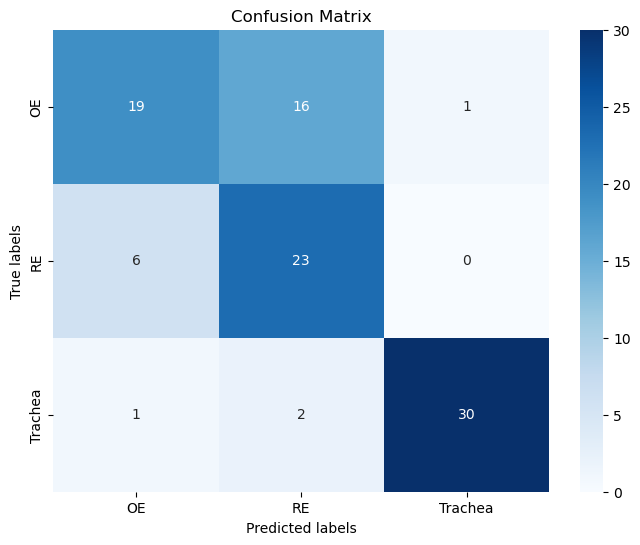

/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

Cross-validation scores: [0.7755102  0.79591837 0.75510204 0.74489796 0.81443299]
Average score: 0.78
Standard deviation of scores: 0.03


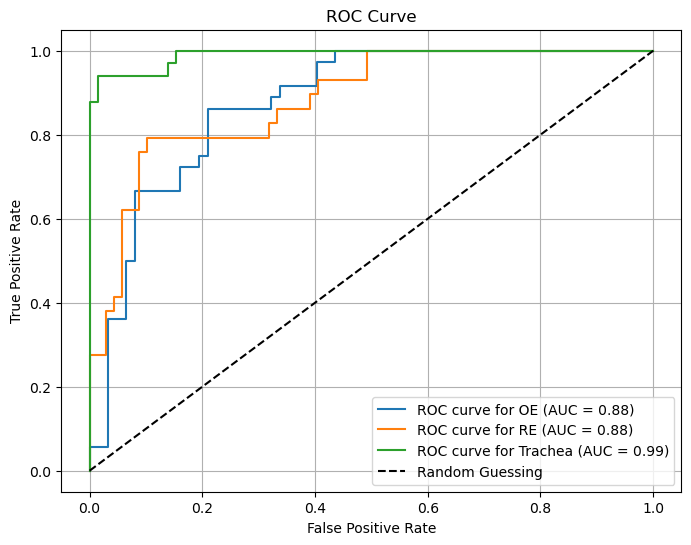

/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

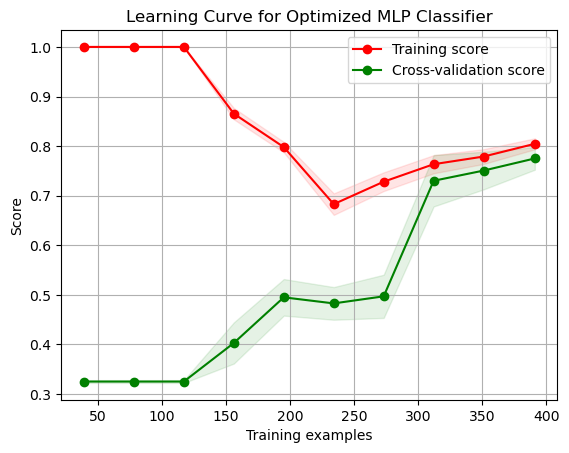

In [4]:
# Process directories
data_oe = process_directory(folder_path_oe, common_wavenumbers)
data_re = process_directory(folder_path_re, common_wavenumbers)
data_trachea = process_directory(folder_path_trachea, common_wavenumbers)


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.neural_network import MLPClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import label_binarize

# Combine the average spectral data into one dataset and create labels
X = np.vstack([data_oe, data_re, data_trachea])
y = np.array([0] * len(data_oe) + [1] * len(data_re) + [2] * len(data_trachea))

# Split the data into a temporary training dataset and final test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary training dataset into actual training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Define the hyperparameter search space for MLP
search_space = {
    'hidden_layer_sizes': Integer(50, 200),  # Number of neurons in the hidden layer
    'alpha': Real(1e-5, 1e-1, prior='log-uniform'),  # Regularization parameter
    'learning_rate_init': Real(1e-4, 1e-1, prior='log-uniform'),  # Initial learning rate
    'activation': Categorical(['tanh', 'relu']),  # Activation function
}

# Initialize the MLP model
model = MLPClassifier(max_iter=500, random_state=42)

# Initialize Bayesian Optimization search
bayes_search = BayesSearchCV(
    model,
    search_spaces=search_space,
    n_iter=30,  # Number of optimization iterations
    cv=5,       # Cross-validation strategy
    random_state=42,
    n_jobs=-1   # Use all available CPU cores
)

# Perform the search for the best hyperparameters
bayes_search.fit(X_train, y_train)

# Best parameters found by Bayesian Optimization
print(f"Best parameters: {bayes_search.best_params_}")

# Evaluate the best model on the test set
best_model = bayes_search.best_estimator_
y_pred = best_model.predict(X_test)

# Classification report and confusion matrix
class_names = ['OE', 'RE', 'Trachea']
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Perform 10-fold cross-validation on the best model
scores = cross_val_score(best_model, X, y, cv=5)

# Calculate and print the average and standard deviation of the scores
average_score = np.mean(scores)
std_deviation = np.std(scores)

print("Cross-validation scores:", scores)
print("Average score:", f"{average_score:.2f}")
print("Standard deviation of scores:", f"{std_deviation:.2f}")

# Plot ROC curve
y_prob = best_model.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

plt.figure(figsize=(8, 6))
for class_index in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, class_index], y_prob[:, class_index])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for {class_names[class_index]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot learning curve
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curve for the best MLP model
title = "Learning Curve for Optimized MLP Classifier"
plot_learning_curve(best_model, title, X, y, cv=5)
plt.show()


In [5]:
# Überprüfen der verwendeten Wellenlängen nach dem Zuschnitt
used_wavenumbers = common_wavenumbers[(common_wavenumbers >= 900) & (common_wavenumbers <= 1800)]
print("Verwendete Wellenlängen:", used_wavenumbers)

# Überprüfen der Form der Trainingsdaten nach dem Zuschnitt
print("Shape der Trainingsdaten:", X_train.shape)
print("Erwartete Anzahl der Features (Wellenlängen):", len(used_wavenumbers))


Verwendete Wellenlängen: [1800 1799 1798 1797 1796 1795 1794 1793 1792 1791 1790 1789 1788 1787
 1786 1785 1784 1783 1782 1781 1780 1779 1778 1777 1776 1775 1774 1773
 1772 1771 1770 1769 1768 1767 1766 1765 1764 1763 1762 1761 1760 1759
 1758 1757 1756 1755 1754 1753 1752 1751 1750 1749 1748 1747 1746 1745
 1744 1743 1742 1741 1740 1739 1738 1737 1736 1735 1734 1733 1732 1731
 1730 1729 1728 1727 1726 1725 1724 1723 1722 1721 1720 1719 1718 1717
 1716 1715 1714 1713 1712 1711 1710 1709 1708 1707 1706 1705 1704 1703
 1702 1701 1700 1699 1698 1697 1696 1695 1694 1693 1692 1691 1690 1689
 1688 1687 1686 1685 1684 1683 1682 1681 1680 1679 1678 1677 1676 1675
 1674 1673 1672 1671 1670 1669 1668 1667 1666 1665 1664 1663 1662 1661
 1660 1659 1658 1657 1656 1655 1654 1653 1652 1651 1650 1649 1648 1647
 1646 1645 1644 1643 1642 1641 1640 1639 1638 1637 1636 1635 1634 1633
 1632 1631 1630 1629 1628 1627 1626 1625 1624 1623 1622 1621 1620 1619
 1618 1617 1616 1615 1614 1613 1612 1611 1610 1609 1

/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

TypeError: only integer scalar arrays can be converted to a scalar index

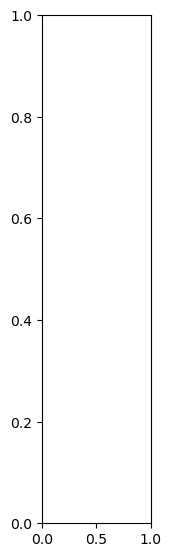

In [13]:
import numpy as np
import shap
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Beispiel-Daten laden (hier verwenden wir Iris-Datensatz als Beispiel)
iris = load_iris()
X = iris.data
y = iris.target

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MLP-Modell initialisieren und trainieren
model = MLPClassifier(random_state=42)
model.fit(X_train, y_train)

# Hintergrunddaten mit shap.sample oder shap.kmeans definieren (beispielhaft shap.sample mit 100 Datenpunkten)
background_sample = shap.sample(X_train, 100)

# Initialize the SHAP explainer with the MLP model and the background sample
explainer = shap.KernelExplainer(model.predict_proba, background_sample)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=iris.feature_names)

# Visualize the SHAP values for the first prediction (index 0)
shap.initjs()
shap.force_plot(explainer.expected_value[y_train[0]], shap_values[y_train[0]][0], X_test[y_train[0]], feature_names=iris.feature_names)
